# Importing models needed for data manipulation and extraction 🕸
 

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2  #for image processing
import numpy as np  #mathematical models for data manipulation

from IPython.display import display

#Toold for encoding and Split data into Train/Test Sets
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Tensorflow Keras CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

#Plot Images
import matplotlib.pyplot as plt

#Binding inputs from directory
import os

# Set the maximum number of lines to print
max_lines = 10
line_count = 0

# Walk through the directory '/kaggle/input' and print the path of each file
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        # Increment the line count
        line_count += 1

        # Check if the maximum number of lines is reached
        if line_count >= max_lines:
            break

    # Check if the maximum number of lines is reached
    if line_count >= max_lines:
        break


/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg


# Preparing image data for classification task 🛩

> ***This code loads images from the kaggle input directory, resizing them to a common size (128x128), and then converting the labels to numerical values.***

>**Steps employed are Label Encoding and One-Hot Encoding,Data Normaliztion and Train-Test spilt **

In [31]:
data = []
label = []

SIZE = 128  # Crop the image to 128x128
num_test_samples = 50
folder_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
for folder in os.listdir(folder_dir):
    for file in os.listdir(os.path.join(folder_dir, folder)):
        if file.endswith("jpg"):
            label.append(folder)
            img = cv2.imread(os.path.join(folder_dir, folder, file))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im = cv2.resize(img_rgb, (SIZE, SIZE))
            data.append(im)
        # Add an else block if needed, depending on your requirements
        # For example, if you want to skip files that don't end with "jpg"
        # else:
        #     continue

data_arr = np.array(data)
label_arr = np.array(label)

# Use LabelEncoder to convert categorical labels to numerical values
encoder = LabelEncoder()
y = encoder.fit_transform(label_arr)

# Convert numerical labels to one-hot encoded format
y = to_categorical(y, 5)

# Normalize the pixel values in the image data
X = data_arr / 255

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_samples, random_state=10)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Number of samples:", len(data))
print("Number of labels:", len(label))


Shape of X: (171, 128, 128, 3)
Shape of y: (171, 5)
Number of samples: 171
Number of labels: 171


# Inspecting Data 🔎 
>*Manually inspecting a few samples from the  dataset to ensure that images are being loaded correctly and that labels are assigned appropriately.*


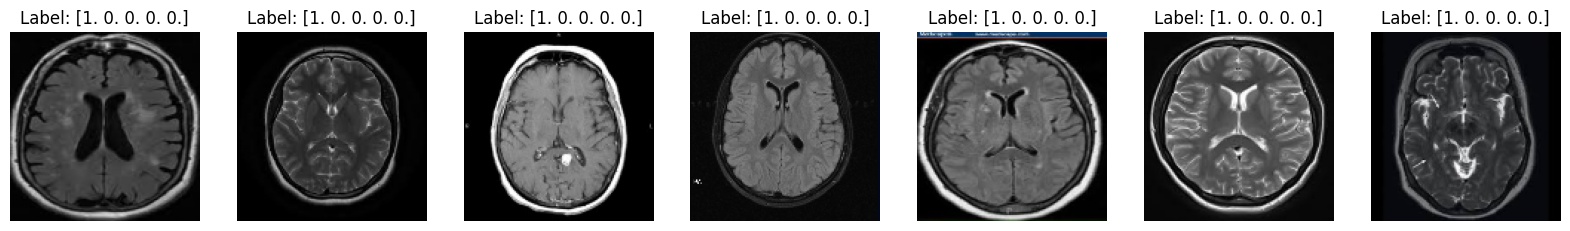

In [32]:
import matplotlib.pyplot as plt
import numpy 

# Visualize a few images horizontally
num_images = 7 # Adjust the number of images to display
fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

for i in range(num_images):
    axes[i].imshow(X[i])
    axes[i].set_title(f"Label: {y[i]}")
    axes[i].axis('off')

plt.show()

# Comparing original and argumented images 
>This code uses Matplotlib to visualize a few original and augmented images from the dataset. This is a great way to inspect how the data augmentation is affecting the input images

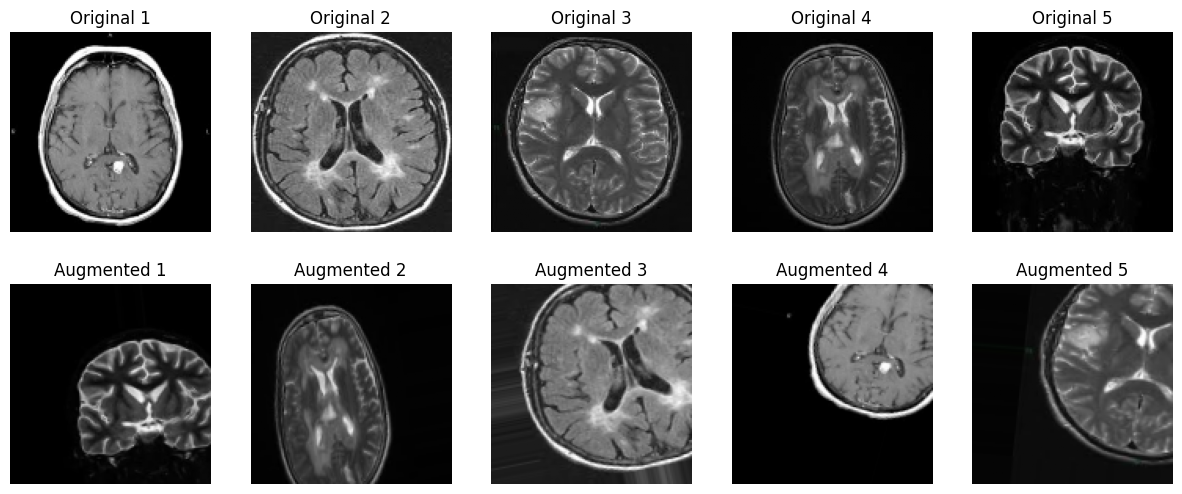

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Data Augmentation:
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range = 0.20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

# Visualize a few original images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(X_train[i])
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')

# Visualize augmented images
augmented_images = datagen.flow(X_train[:5], batch_size=1)

for i in range(5):
    augmented_image = augmented_images.next()[0]
    axes[1, i].imshow(augmented_image)
    axes[1, i].set_title(f'Augmented {i+1}')
    axes[1, i].axis('off')

plt.show()


# Convolutional Neural Network (CNN)  model architecture ⚗
> It consists of convolutional layers followed by max-pooling layers, a flatten layer, fully connected (dense) layers, and a softmax output layer for classification. 
>>The first convolutional layer has 64 filters with a kernel size of (3, 3), using the 'relu' activation function.
>>>The second set of three convolutional layers (with 128 filters each) is followed by max-pooling layers with a pool size of (2, 2). This combination helps extract hierarchical features from the input images.

>Flatten Layer:
>>Flattens the output from the convolutional layers into a 1D array, preparing it for the fully connected layers.

>Fully Connected Layers:
>>Two dense layers with 128 and 64 neurons, respectively, both using the 'relu' activation function.
Dropout Layer:

Introduces dropout with a rate of 0.5 to reduce overfitting during training.
Output Layer:

The final layer has 5 neurons (assuming a 5-class classification problem) and 'softmax' activation for multi-class classification.

In [34]:

model = Sequential()

# Convolutional layers
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Dropout layer to prevent overfitting
model.add(Dropout(rate=0.5))

# Output layer with softmax activation for multi-class classification
model.add(Dense(5, activation='softmax'))


# Training the model ⚙
>Training the deep learning model using **data augmentation**, evaluating it on a test set, and visualizing both individual predictions and the training history.

Epoch 1/64
4/4 [==============================] - 3s 150ms/step - loss: 1.3442 - accuracy: 0.3967 - val_loss: 0.6805 - val_accuracy: 0.6000
Epoch 2/64
4/4 [==============================] - 1s 122ms/step - loss: 0.9147 - accuracy: 0.5537 - val_loss: 0.6961 - val_accuracy: 0.6200
Epoch 3/64
4/4 [==============================] - 1s 123ms/step - loss: 0.8996 - accuracy: 0.5455 - val_loss: 0.7253 - val_accuracy: 0.5800
Epoch 4/64
4/4 [==============================] - 1s 139ms/step - loss: 0.7843 - accuracy: 0.5785 - val_loss: 0.6968 - val_accuracy: 0.5800
Epoch 5/64
4/4 [==============================] - 1s 129ms/step - loss: 0.8709 - accuracy: 0.4463 - val_loss: 0.6642 - val_accuracy: 0.8000
Epoch 6/64
4/4 [==============================] - 1s 125ms/step - loss: 0.7892 - accuracy: 0.5455 - val_loss: 0.6270 - val_accuracy: 0.8000
Epoch 7/64
4/4 [==============================] - 1s 131ms/step - loss: 0.8198 - accuracy: 0.5289 - val_loss: 0.6217 - val_accuracy: 0.6600
Epoch 8/64
4/4 [====

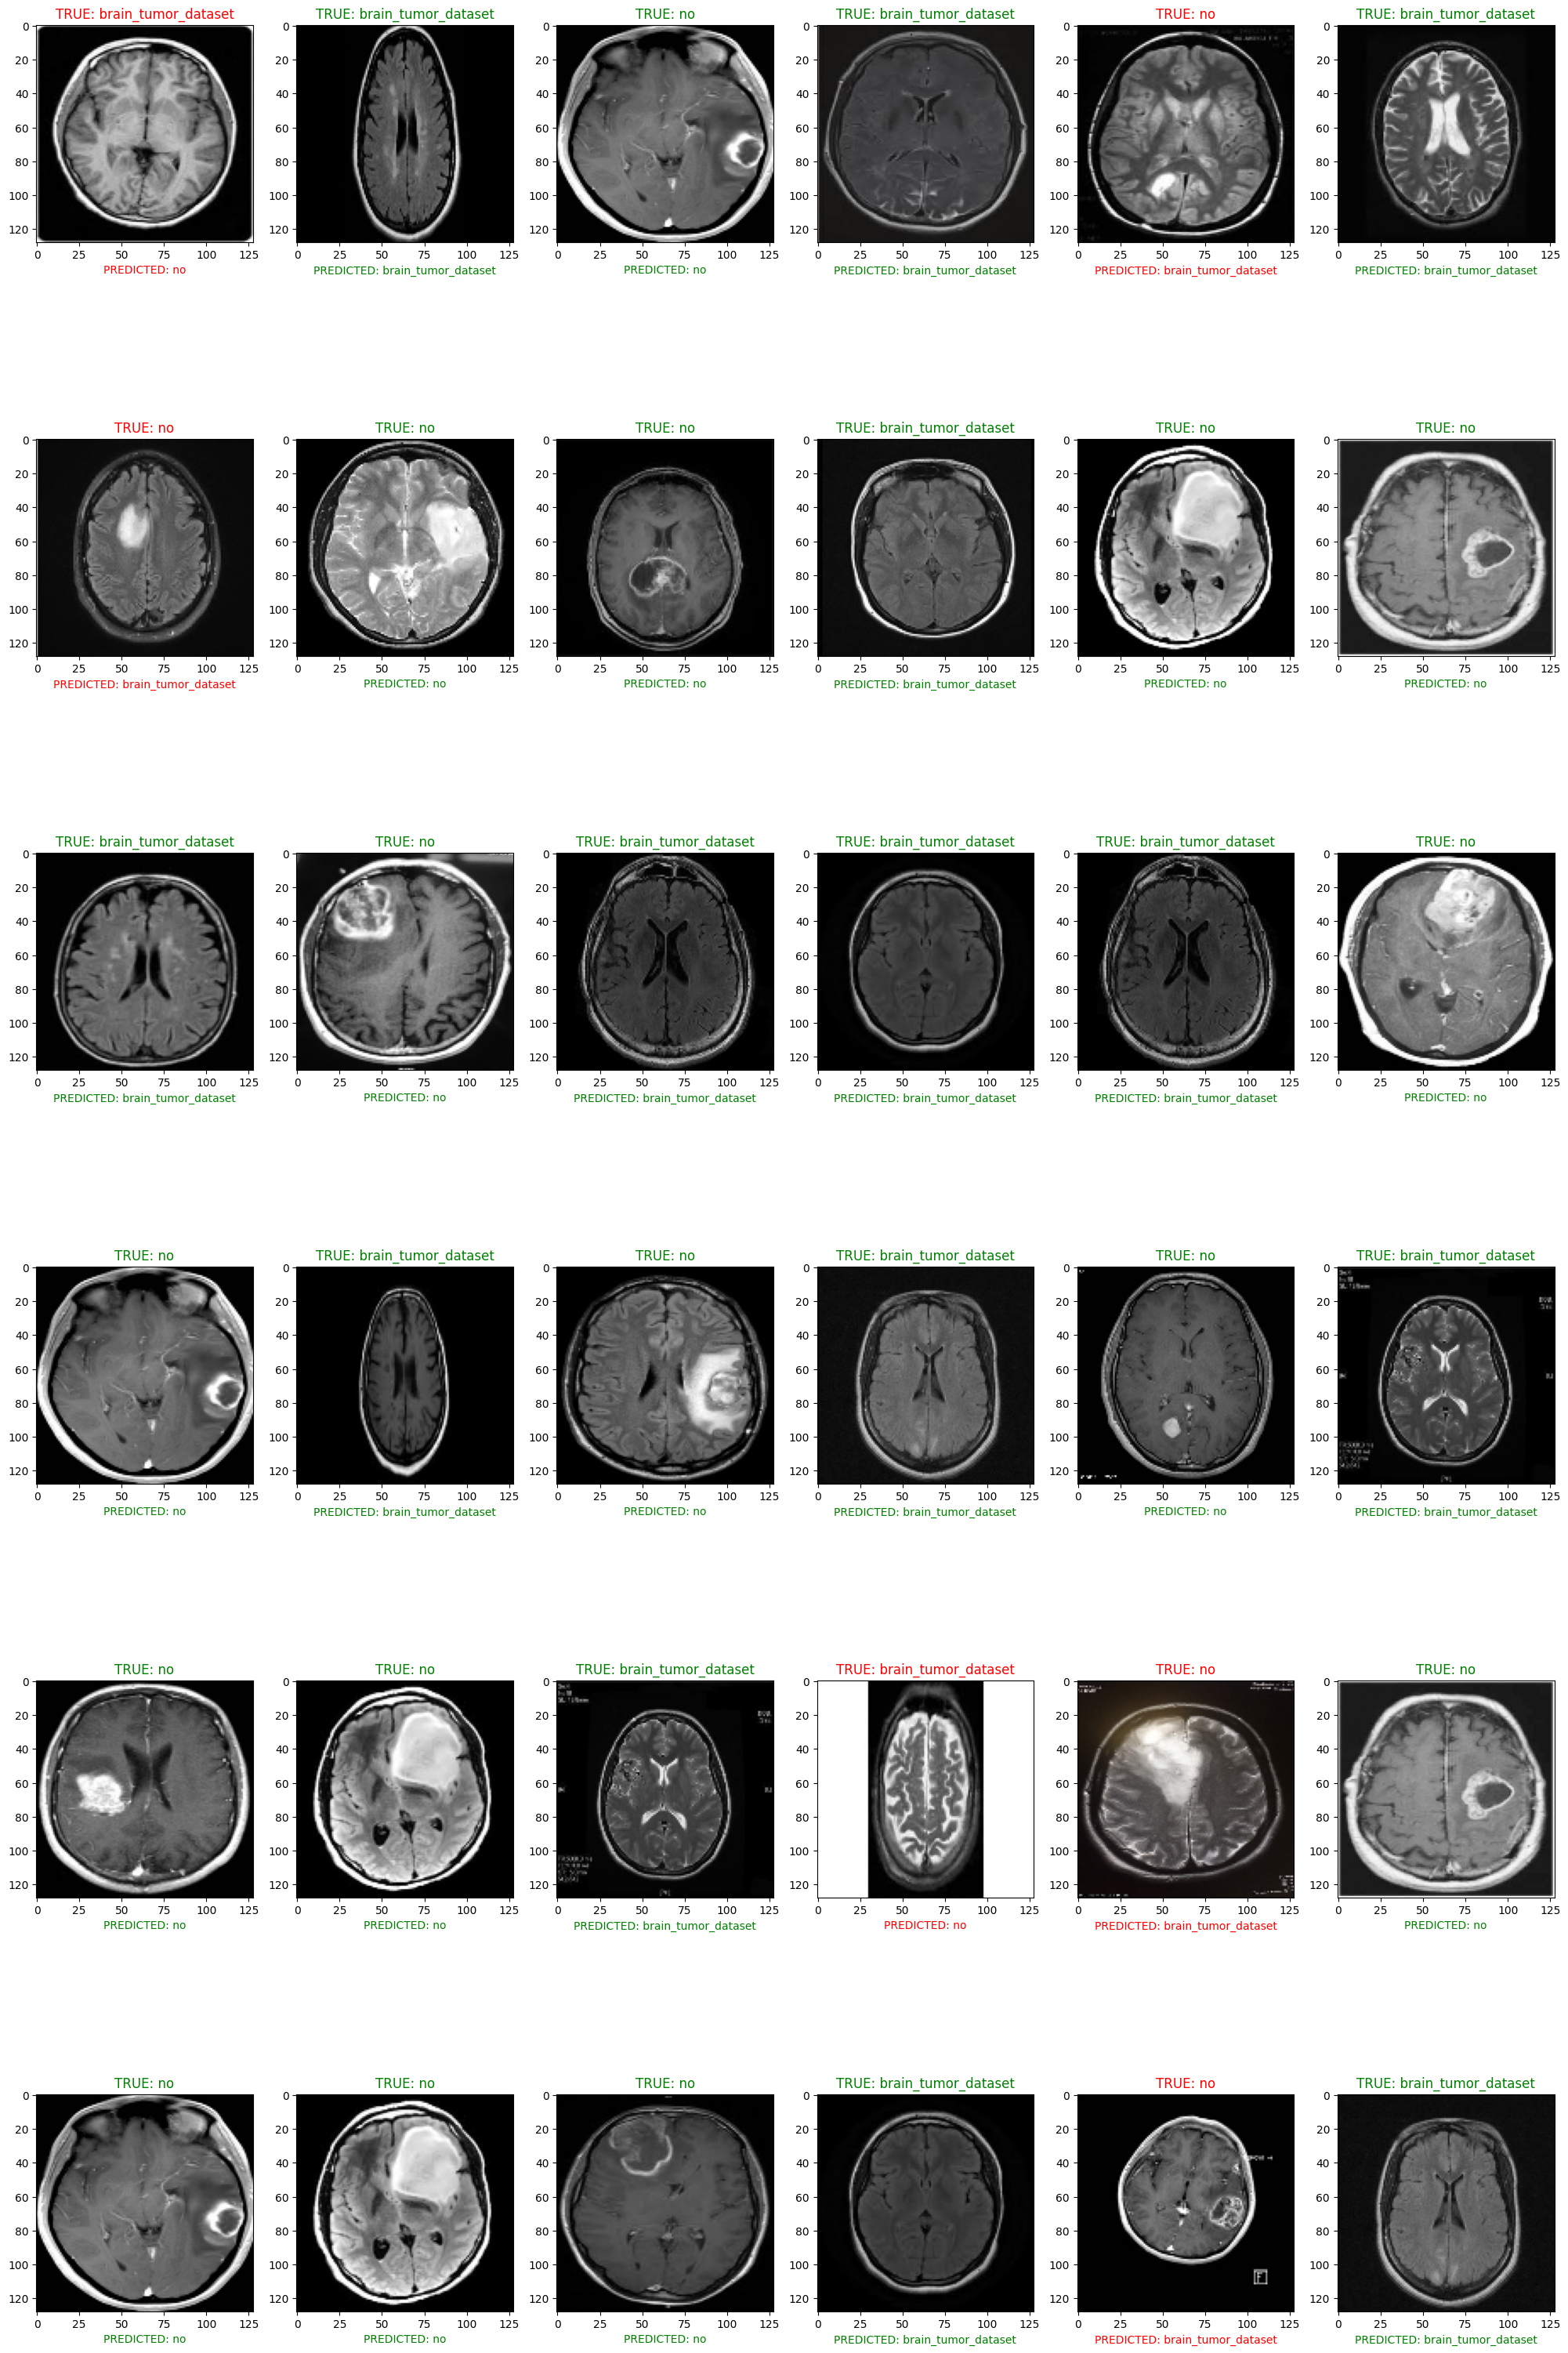

In [35]:
# Assuming you have imported necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

# Model Compilation and Training:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 32
epochs = 64
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    verbose=1)

# Individual Predictions Visualization:
categories = np.sort(os.listdir(folder_dir))
fig, ax = plt.subplots(6, 6, figsize=(25, 40))


from sklearn.metrics import confusion_matrix
import seaborn as sns

for i in range(6):
    for j in range(6):
        k = int(np.random.random_sample() * len(X_test))
        if (categories[np.argmax(y_test[k])] == categories[np.argmax(model.predict(X_test)[k])]):
            ax[i, j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='green')
            ax[i, j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='green')
            ax[i, j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')
        else:
            ax[i, j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='red')
            ax[i, j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='red')
            ax[i, j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')


# Visualize training history using Altair
history_df = pd.DataFrame(history.history)
history_df['epoch'] = range(1, len(history.history['accuracy']) + 1)

# Melt the dataframe for Altair visualization
history_melted = pd.melt(history_df, id_vars=['epoch'], var_name='metric', value_name='value')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

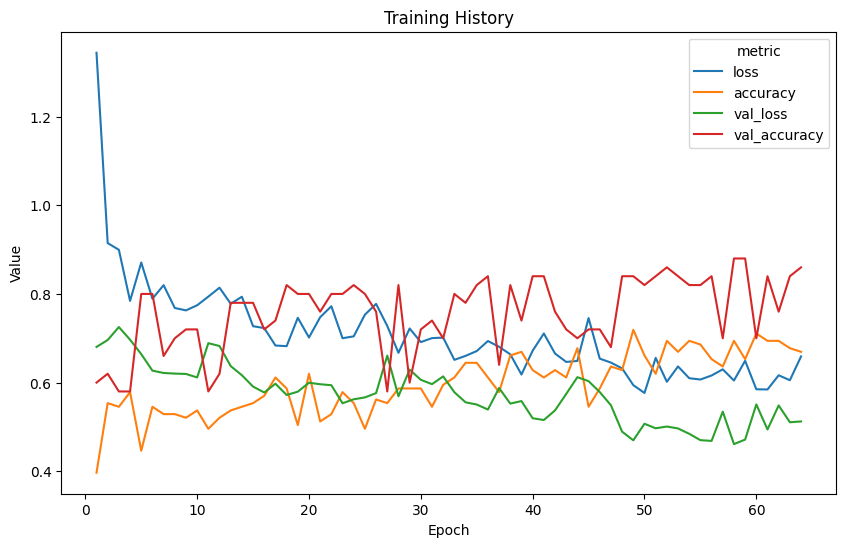

2/2 [==============================] - 0s 21ms/step - loss: 0.5124 - accuracy: 0.8600
Validation Accuracy: 0.86


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming history_melted is a DataFrame with columns: 'epoch', 'value', 'metric'

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=history_melted, x='epoch', y='value', hue='metric')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')

# Show the plot
plt.show()

# Evaluating model on the validation set
validation_loss, validation_accuracy = model.evaluate(X_test, y_test)
print(f'Validation Accuracy: {validation_accuracy:.2f}')
